<a href="https://colab.research.google.com/github/fringewidth/felineflow/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Train FelineFlow**
In this notebook, we will train a diffusion model to generate 256x256 images of cats🐈

## Setup
Let's use Google's TPUs to speed up the training process, and also import other necessary modules.

In [2]:
# !pip install cloud-tpu-client==0.10 torch==2.0.0 torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl

  ERROR: HTTP error 403 while getting https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl
ERROR: Could not install requirement torch-xla==2.0 from https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl because of HTTP error 403 Client Error: Forbidden for url: https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl for URL https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl


In [2]:
# import torch_xla
# import torch_xla.core.xla_model as xm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import math

In [3]:
dev = "cuda"

## 🔃Loading cute cats...
Let's import the dataset. I've used 4096 images of cats from [Microsoft Research's Cats vs. Dogs Dataset.](https://www.microsoft.com/en-us/download/details.aspx?id=54765)
I've cropped the data to a 256x256 resolution.
The processed data is available [here](https://github.com/fringewidth/felineflow/blob/main/cats_processed.zip) as a `.zip`.

In [ ]:
#get dataset
!wget https://github.com/fringewidth/felineflow/raw/main/cats_processed.zip
!mkdir -p dataset/cats
!unzip cats_processed.zip -d dataset/cats

In [5]:
cats = torchvision.datasets.ImageFolder(root='dataset', transform = torchvision.transforms.ToTensor())

In [6]:
#get dataloader
cats_loader = torch.utils.data.DataLoader(cats, batch_size=64, shuffle=True)

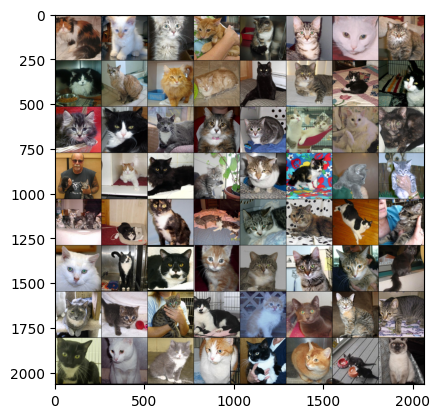

In [ ]:
#get sample batch
sample_batch, labels = next(iter(cats_loader))
assert sample_batch.size(2) == 256 and sample_batch.size(3) == 256, "Images must be 256x256"

#make grid image
grid = torchvision.utils.make_grid(sample_batch)

#convert CHW(channels, height, width) to HWC and display
grid = grid.permute(1, 2, 0)
plt.imshow(grid)
plt.show()

## ⏩Forward Diffusion
Let's now implement the forward diffusion process

In [ ]:
#function to get a linear noise schedule
def get_noise_schedule(start, end, timesteps, device):
  beta = torch.linspace(start, end, timesteps, device=device)
  alpha = 1 - beta
  alpha_bar = torch.cumprod(alpha, dim=0)
  return beta, alpha, alpha_bar

In [ ]:
def get_noised_image(image, alpha_bar, t):
  image_t = image * torch.sqrt(alpha_bar[t]) + torch.sqrt((1-alpha_bar[t])) * torch.randn_like(image)
  return image_t

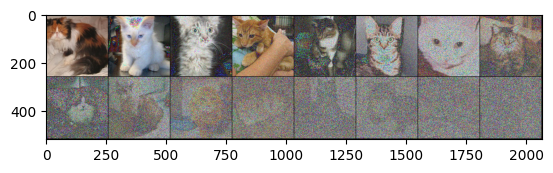

In [ ]:
#test forward diffusion
sample_steps = 128
beta, alpha, alpha_bar = get_noise_schedule(1e-4, 0.02, sample_steps, device=dev)
img_arr = torch.empty(sample_steps, 3, 256, 256, device=dev)
for t in range(sample_steps):
    img_arr[t] = (get_noised_image(sample_batch[t % len(sample_batch)].to(dev), alpha_bar, t) * 255).clamp(0, 255).type(torch.uint8)

noised_grid = torchvision.utils.make_grid(img_arr).permute(1, 2, 0)
plt.imshow(noised_grid.type(torch.uint8).cpu())
plt.show()

## ⏪Backward Diffusion
Let's now implement the U-Net that predicts the reverse diffusion process. I've designed the U-Net as follows, taking the following into consideration:
- Experimental evidence of better performance from [Prafulla Dhariwal et al.](https://arxiv.org/abs/2105.05233) on increasing the depth of the network while decreasing the width; i.e., large number of convolutional layers with gradual increasing of the number of channels.
- Strategic placement of self-attention modules to capture both resolution and a large amount of features.
- Alternate skip connections to preserve high level semantic information while reducing computational overhead.
- Computationally efficient ReLU activation functions for quick training and inference, while still experimenting with more exotic activations for the attention modules.
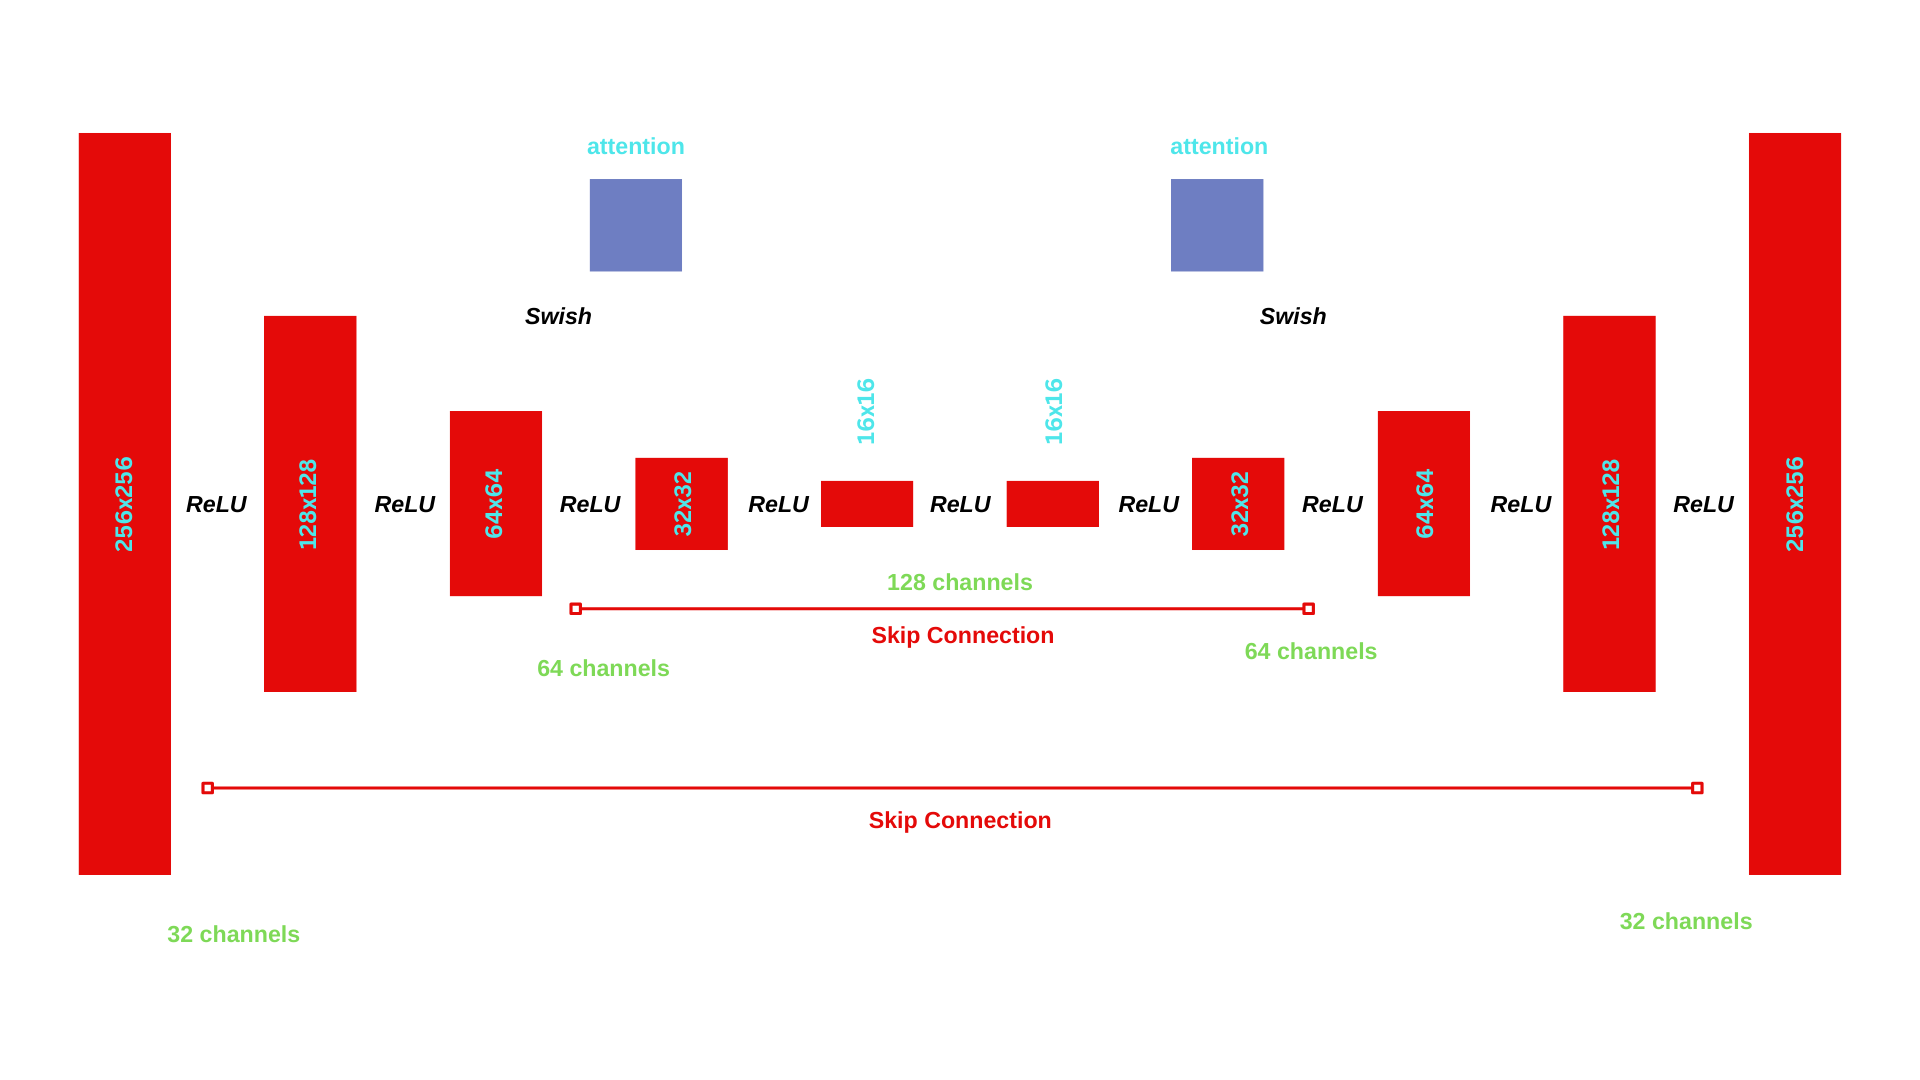

###Define an enumeration for Activation functions

In [ ]:
from enum import Enum
class ActivationFunction(Enum):
  RELU = 0
  SWISH = 1

### Define the timestep encoding
We will use the Sinusoidal Embedding first used for the transformer architecture in the famous [Attention is all you need](https://arxiv.org/abs/1706.03762) paper.

In [ ]:
def SinusoidalEmbedding(timestep, dim, n=10000):
  assert dim % 2 == 0, "Dimension must be even"
  if isinstance(timestep, int):
      timestep = torch.tensor([timestep], device=dev).float()
  pos = torch.arange(dim // 2, device=timestep.device).float()
  emb = timestep[:, None] * torch.exp(-2 * math.log(n) / dim * pos)
  return torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)

### Define the encoder module
The encoder module in our U-Net downsamples the input image by 2 and doubles the number of channels.

The decoder module has two ReLU activating convolutional layers and a max pooling layer. The second convolutional layer doubles the number of channels, while the max pool layer is responsible for halving the resolution.

In [ ]:
class Encoder(nn.Module):
  def __init__(self, in_channels, out_channels, activation_function=ActivationFunction.RELU, kernel_size=3, stride=1, padding=1):
    super().__init__()
    self.time_dim = 32
    self.activation = nn.ReLU() if activation_function == ActivationFunction.RELU else nn.SiLU()
    self.pre = nn.Sequential(
        nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding),
        nn.BatchNorm2d(in_channels),
        self.activation
    )
    self.timeEmb = nn.Sequential(
        nn.Linear(self.time_dim, in_channels),
        nn.ReLU()
    )
    self.post = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.BatchNorm2d(out_channels),
        self.activation,
        nn.MaxPool2d(2),
        nn.BatchNorm2d(out_channels),
        self.activation
    )

  def forward(self, x, timestep):
    pre = self.pre(x)
    time_emb = self.timeEmb(SinusoidalEmbedding(timestep, self.time_dim))
    pre = pre + time_emb[:, :, None, None].repeat(1, 1, pre.size(-2), pre.size(-1))
    post = self.post(pre)
    return post

### Define the decoder module
The decoder module reverses the encoding process, i.e halves the number of channels and doubles the resolution. We employ three layers in the decoder for this purpose. The first two layers perform the transpose convolution operation, where the second layer halves the number of channels. This is followed by a regular convolution operation.

In [ ]:
class Decoder(nn.Module):
  def __init__(self, in_channels, out_channels, activation_function=ActivationFunction.RELU, kernel_size=3, stride=1, padding=1):
    super().__init__()
    self.time_dim = 32
    self.activation = nn.ReLU() if activation_function == ActivationFunction.RELU else nn.SiLU()
    self.pre = nn.Sequential(
        nn.ConvTranspose2d(in_channels, in_channels, 4, 2, 1),
        nn.BatchNorm2d(in_channels),
        self.activation
    )
    self.timeEmb = nn.Sequential(
        nn.Linear(self.time_dim, in_channels),
        nn.ReLU()
    )
    self.post = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.BatchNorm2d(out_channels),
        self.activation,
    )

  def forward(self, x, timestep):
    pre = self.pre(x)
    time_emb = self.timeEmb(SinusoidalEmbedding(timestep, self.time_dim))
    pre = pre + time_emb[:, :, None, None].repeat(1, 1, pre.size(-2), pre.size(-1))
    post = self.post(pre)
    return post

### Attention Module
We use the attention module


In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, channels, size, activation_function=ActivationFunction.SWISH):
    super(SelfAttention, self).__init__()
    self.channels = channels
    self.size = size
    self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
    self.ln = nn.LayerNorm([channels])
    self.activation = nn.SiLU() if activation_function == ActivationFunction.SWISH else nn.ReLU()
    self.fullconn = nn.Sequential(
        nn.LayerNorm([channels]),
        nn.Linear(channels, channels),
        nn.SiLU()
    )

  def forward(self, x):
    if x.dim() == 3:
        x = x.unsqueeze(0)  # Add batch dimension if missing
    batch_size, channels, height, width = x.size()
    x = self.activation(x)
    x = x.view(batch_size, channels, height * width)
    x = x.swapaxes(1, 2)
    x = self.ln(x)
    att, _ = self.mha(x, x, x)
    att = att + x
    att = self.fullconn(att)
    return att.swapaxes(2, 1).view(batch_size, channels, height, width)

In [ ]:
class UNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.UNet = nn.ModuleList([
        Encoder(3, 32),
        Encoder(32, 64),
        Encoder(64, 128),
        SelfAttention(128, 32),
        Encoder(128, 128),
        Decoder(128, 128),
        SelfAttention(128, 32),
        Decoder(128, 64),
        Decoder(64, 32),
        Decoder(32, 3)
    ])

  def forward(self, x, timestep):
    skips = []
    for i, m in enumerate(self.UNet):
        if i in [7, 9]:
            x = x + skips.pop()
        if isinstance(m, SelfAttention):
            x = m(x)
        else:
            x = m(x, timestep)
        if i in [0, 2]:
            skips.append(x)
    return x

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


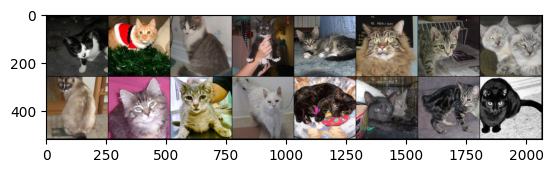

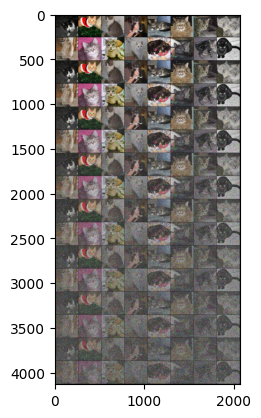

Epoch 1/100, Loss: 0.0522
Epoch 2/100, Loss: 0.0247
Epoch 3/100, Loss: 0.0189
Epoch 4/100, Loss: 0.0157
Epoch 5/100, Loss: 0.0136
Epoch 6/100, Loss: 0.0122
Epoch 7/100, Loss: 0.0113
Epoch 8/100, Loss: 0.0109
Epoch 9/100, Loss: 0.0105
Epoch 10/100, Loss: 0.0102
Epoch 11/100, Loss: 0.0099
Epoch 12/100, Loss: 0.0098
Epoch 13/100, Loss: 0.0096
Epoch 14/100, Loss: 0.0095
Epoch 15/100, Loss: 0.0093
Epoch 16/100, Loss: 0.0092
Epoch 17/100, Loss: 0.0091
Epoch 18/100, Loss: 0.0090
Epoch 19/100, Loss: 0.0090
Epoch 20/100, Loss: 0.0089
Epoch 21/100, Loss: 0.0089
Epoch 22/100, Loss: 0.0088
Epoch 23/100, Loss: 0.0087
Epoch 24/100, Loss: 0.0087
Epoch 25/100, Loss: 0.0086
Epoch 26/100, Loss: 0.0086
Epoch 27/100, Loss: 0.0086
Epoch 28/100, Loss: 0.0085
Epoch 29/100, Loss: 0.0084
Epoch 30/100, Loss: 0.0080
Epoch 31/100, Loss: 0.0059
Epoch 32/100, Loss: 0.0037
Epoch 33/100, Loss: 0.0033
Epoch 34/100, Loss: 0.0030
Epoch 35/100, Loss: 0.0029
Epoch 36/100, Loss: 0.0027
Epoch 37/100, Loss: 0.0026
Epoch 38/1

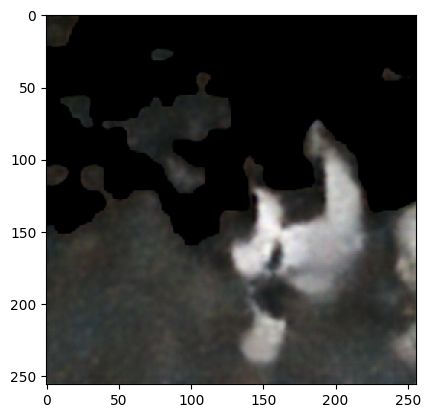

In [7]:
def train_model(model, dataloader, optimizer, criterion, num_epochs, accumulation_steps=4):
    model.train()
  for epoch in range(num_epochs):
    running_loss = 0.0
    optimizer.zero_grad()
    for i, (images, _) in enumerate(dataloader):
      images = images.to(dev)
      t = torch.randint(0, sample_steps, (images.size(0),), device=dev).long()
      noised_images = torch.stack([get_noised_image(images[i], alpha_bar, t[i]) for i in range(images.size(0))])
      outputs = model(noised_images, t)
      loss = criterion(outputs, images)
      loss = loss / accumulation_steps
      loss.backward()
      if (i + 1) % accumulation_steps == 0:
        optimizer.step()
        optimizer.zero_grad()
      running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

unet = UNet().to(dev)
criterion = nn.MSELoss()
optimizer = optim.Adam(unet.parameters(), lr=1e-4)

num_epochs = 100
train_model(unet, cats_loader, optimizer, criterion, num_epochs)

try:
  _, _, alpha_bar = get_noise_schedule(1e-4, 0.02, 128, device=dev)
  unet.eval()
  t = torch.tensor([72], device=dev).long()
  x = get_noised_image(sample_batch[0].to(dev), alpha_bar, t)
  if x.dim() == 3:
      x = x.unsqueeze(0)
  output = unet(x, t).squeeze(0).permute(1, 2, 0)
  output = (output * 255).clamp(0, 255).type(torch.uint8).detach().cpu().numpy()
  plt.imshow(output)
  plt.show()
except Exception as e:
  Print(f"An error occurred: {e}")